# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)
### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==1.12**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Needed librairies

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import gzip
import sys
import _pickle as cPickle
import os

In [2]:
tf.__version__

'1.12.0'

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)

## Import the Data

In [66]:
# get mnist data, split between train and test sets
# on GCP
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# with AXA network
def load_data(path):
    f = gzip.open(path, 'rb')
    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')
    f.close()
    return data
(x_train, y_train), (x_test, y_test) = load_data(path='../data/mnist.pkl.gz')

In [67]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [68]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [69]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [70]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

In [71]:
x_test.nbytes/1024.0**2

7.476806640625

In [72]:
x_train.nbytes/1024.0**2

44.86083984375

In [73]:
y_test.nbytes/1024.0**2

0.0095367431640625

In [74]:
y_train.nbytes/1024.0**2

0.057220458984375

## Stored the data as TFRecord
https://medium.com/coinmonks/storage-efficient-tfrecord-for-images-6dc322b81db4
https://www.damienpontifex.com/2017/09/18/convert-and-using-the-mnist-dataset-as-tfrecords/

In [380]:
def _int64_feature(value:int) -> tf.train.Features.FeatureEntry:
    """Create a Int64List Feature
    
    Args:
        value: The value to store in the feature
    
    Returns:
        The FeatureEntry
    """
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [398]:
def _floatlist_feature(value:str) -> tf.train.Features.FeatureEntry:
    """Create a FloatList Feature
    
    Args:
        value: The value to store in the feature
    
    Returns:
        The FeatureEntry
    """
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [399]:
def _bytes_feature(value:str) -> tf.train.Features.FeatureEntry:
    """Create a BytesList Feature
    
    Args:
        value: The value to store in the feature
    
    Returns:
        The FeatureEntry
    """
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [400]:
def _data_path(data_directory:str, name:str) -> str:
    """Construct a full path to a TFRecord file to be stored in the 
    data_directory. Will also ensure the data directory exists
    
    Args:
        data_directory: The directory where the records will be stored
        name:           The name of the TFRecord
    
    Returns:
        The full path to the TFRecord file
    """
    if not os.path.isdir(data_directory):
        os.makedirs(data_directory)

    return os.path.join(data_directory, f'{name}.tfrecords')

In [441]:
def _process_examples(example_dataset, filename:str):
    print(f'Processing {filename} data')
    dataset_length = len(example_dataset)
    with tf.python_io.TFRecordWriter(filename) as writer:
        for index, (image, label) in enumerate(example_dataset):
            sys.stdout.write(f"\rProcessing sample {index+1} of {dataset_length}")
            sys.stdout.flush()
            image_raw = image.tostring()
            #print('step 2:',image_raw)
            #print('step 1:',image.shape)
            example = tf.train.Example(features=tf.train.Features(feature={
                'label': _int64_feature(int(label)),
                'image_raw': _bytes_feature(image_raw)# _floatlist_feature(image.reshape(-1)) #
            }))
            #example = tf.train.Example()
            #example.features.feature['label'].int64_list.value.append(int(label))
            #img_64 = np.asarray(dict_to_img(drawing, img_sz=64, lw=4, maximize=True)).reshape(-1)
            #example.features.feature['image_raw'].int64_list.value.extend(image.reshape(-1))
            
            writer.write(example.SerializeToString())
        print()

In [442]:
def convert_to(x_data, y_data, name:str, data_directory:str, num_shards:int=1):
    """Convert the dataset into TFRecords on disk
    
    Args:
        x_data:         The MNIST data set to convert: data
        y_data:         The MNIST data set to convert: label
        name:           The name of the data set
        data_directory: The directory where records will be stored
        num_shards:     The number of files on disk to separate records into
    """

    data_set = list(zip(x_data, y_data))
    
    if num_shards == 1:
        _process_examples(data_set, _data_path(data_directory, name))
    else:
        sharded_dataset = np.array_split(data_set, num_shards)
        for shard, dataset in enumerate(sharded_dataset):
            _process_examples(dataset, _data_path(data_directory, f'{name}-{shard+1}'))

In [443]:
convert_to(x_test, y_test, 'test', os.path.abspath('../data/'), 1)

Processing /Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/data/test.tfrecords data
Processing sample 10000 of 10000


In [444]:
convert_to(x_train, y_train, 'train', os.path.abspath('../data/'), 1)

Processing /Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/data/train.tfrecords data
Processing sample 60000 of 60000


In [526]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda3/bin/python'

In [527]:
!gcloud version

Google Cloud SDK 232.0.0
bq 2.0.40
core 2019.01.27
gsutil 4.35


In [528]:
!gcloud info

Google Cloud SDK [232.0.0]

Platform: [Mac OS X, x86_64] uname_result(system='Darwin', node='Fabien-Tarrades-MacBook-Pro.local', release='18.2.0', version='Darwin Kernel Version 18.2.0: Thu Dec 20 20:46:53 PST 2018; root:xnu-4903.241.1~1/RELEASE_X86_64', machine='x86_64', processor='i386')
Python Version: [3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 14:01:38)  [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]]
Python Location: [/Users/tarrade/anaconda3/bin/python]
Site Packages: [Disabled]

Installation Root: [/Users/tarrade/Test/google-cloud-sdk]
Installed Components:
  gsutil: [4.35]
  core: [2019.01.27]
  bq: [2.0.40]
System PATH: [/Users/tarrade/anaconda3/envs/env_gcp_dl/bin:/Users/tarrade/Test/google-cloud-sdk/bin:/Users/tarrade/anaconda3/bin:/Users/tarrade/anaconda3/condabin:/Users/tarrade/anaconda/bin:/Users/tarrade/anaconda/bin:/Users/tarrade/anaconda/bin:/Users/tarrade/anaconda/bin:/Users/tarrade/anaconda/bin:/Users/tarrade/miniconda2/bin:/opt/local/bin:/opt/local/

In [530]:
os.environ['CLOUDSDK_PYTHON']='/Users/tarrade/anaconda/bin/python'

In [531]:
!gsutil cp ../data/*tfrecords gs://ml-productive-pipeline-53122

Copying file://../data/test.tfrecords [Content-Type=application/octet-stream]...
Copying file://../data/train.tfrecords [Content-Type=application/octet-stream]...
\ [2 files][ 56.2 MiB/ 56.2 MiB]    4.9 MiB/s                                   
Operation completed over 2 objects/56.2 MiB.                                     


## Normalize and reorganize the data

In [13]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [14]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [15]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [16]:
x_train.shape

(60000, 784)

In [17]:
x_test.shape

(10000, 784)

## Reshape the labels

In [18]:
y_train.shape

(60000,)

In [19]:
y_test.shape

(10000,)

In [20]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [21]:
num_classes = len(np.unique(y_train))
num_classes

10

In [22]:
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [23]:
y_train.shape

(60000, 10)

In [24]:
y_test.shape

(10000, 10)

In [25]:
dim_input=x_train.shape[1]
dim_input

784

## Visualize the data

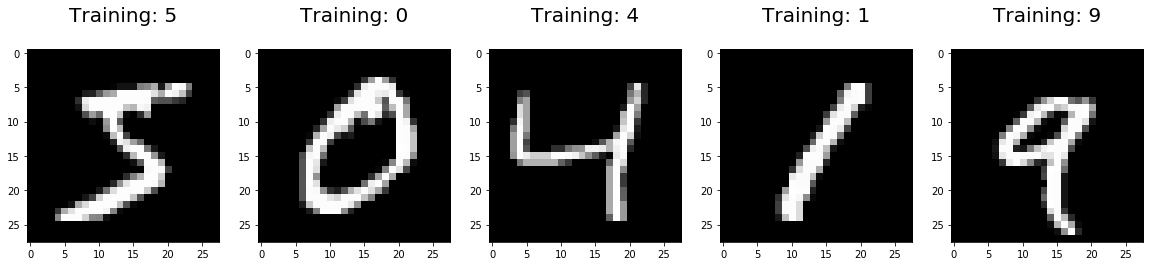

In [26]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % np.argmax(label), fontsize = 20)

## Defined some hyperparameters

In [94]:
# learning rate
learning_rate = 0.5

# number of epoch to train our model
EPOCHS = 10

# size of our mini batch
#BATCH_SIZE = len(x_train)
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = 1 #tf.contrib.data.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# hidden layer 1
n1=300

In [95]:
BATCH_SIZE, EPOCHS

(128, 10)

## Defined flags

In [259]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)
    
del_all_flags(tf.flags.FLAGS)

In [260]:
tf.app.flags.DEFINE_string('f', '', 'kernel') # just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
tf.app.flags.DEFINE_string('model_dir', '../results/Models/Mnist/ckpt/', 'Dir to save a model and checkpoints')
tf.app.flags.DEFINE_string('saved_dir', '../results/Models/Mnist/pb/', 'Dir to save a model for TF serving')
tf.app.flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
tf.app.flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
tf.app.flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
tf.app.flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')
FLAGS = tf.app.flags.FLAGS

In [261]:
print(FLAGS)


/Users/tarrade/anaconda3/envs/env_gcp_dl/lib/python3.6/site-packages/ipykernel_launcher.py:
  --batch_size: Batch size
    (default: '128')
    (an integer)
  --f: kernel
    (default: '')
  --model_dir: Dir to save a model and checkpoints
    (default: '../results/Models/Mnist/ckpt/')
  --num_parallel_calls: Number of paralell calls
    (default: '4')
    (an integer)
  --prefetch_buffer_size: Prefetch buffer size
    (default: '1')
    (an integer)
  --saved_dir: Dir to save a model for TF serving
    (default: '../results/Models/Mnist/pb/')
  --shuffle_buffer_size: Shuffle buffer size
    (default: '1280')
    (an integer)

absl.flags:
  --flagfile: Insert flag definitions from the given file into the command line.
    (default: '')
  --undefok: comma-separated list of flag names that it is okay to specify on
    the command line even if the program does not define a flag with that name.
    IMPORTANT: flags in this list that have arguments MUST use the --flag=value
    format.
   

## Using tf.data.Dataset
https://www.tensorflow.org/guide/performance/datasets  
To summarize, one good order for the different transformations is:
- create the dataset
- shuffle (with a big enough buffer size https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle)
- repeat
- map with the actual work (preprocessing, augmentation…) using multiple parallel calls
- batch
- prefetch

ModeKeys:  
https://www.tensorflow.org/api_docs/python/tf/estimator/ModeKeys  
- EVAL
- PREDICT
- TRAIN

In [491]:
def input_dataset_tfrecords_fn(filenames, batch_size=128, mode=tf.estimator.ModeKeys.TRAIN):
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        tf.logging.info("input_dataset_fn: PREDICT, {}".format(mode))
    elif mode == tf.estimator.ModeKeys.EVAL:
        tf.logging.info("input_dataset_fn: EVAL, {}".format(mode))
    elif mode == tf.estimator.ModeKeys.TRAIN:
        tf.logging.info("input_dataset_fn: TRAIN, {}".format(mode))
    
    def _parser(record):
        # 1. define a parser
        features={
            #'label': tf.FixedLenFeature([], tf.int64),
            #'image_raw': tf.FixedLenFeature([], tf.train.FloatList)#tf.string)
            'label': tf.FixedLenFeature(shape=[], dtype=tf.int64),
            # The bytes_list data is parsed into tf.string.
            'image_raw': tf.FixedLenFeature(shape=[], dtype=tf.string)
        }
        print('step 1')
        parsed_record = tf.parse_single_example(record, features)
        print('step 2')
        print(parsed_record)
        # 2. Convert the data
        label = parsed_record['label']
        #image = parsed_record['image_raw']#
        image =  tf.cast(tf.decode_raw(parsed_record['image_raw'], out_type=tf.uint8), tf.float64)
        print('TEST',label.shape)
        print('TEST',image.shape)
        # 3. reshape
        #tf.reshape(image, [1,784])
        #print('---',image.shape())
        
        # 4. hot emcoding
        num_classes=10
        #label = tf.keras.utils.to_categorical( label, num_classes)
        label=tf.one_hot(label, num_classes)

        return image, label
        #dataset = tf.data.Dataset.from_tensor_slices((image, label))
        #return dataset
    
    def _normalize(image, label):
        """Convert image from [0, 255] -> [-0.5, 0.5] floats."""
        image = image * (1. / 255) - 0.5
        return image, label
    
    def _dense_to_one_hot(labels_dense, num_classes):
        """Convert class labels from scalars to one-hot vectors."""
        num_labels = labels_dense.shape[0]
        index_offset = numpy.arange(num_labels) * num_classes
        labels_one_hot = numpy.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
        return labels_one_hot
    
    def _input_fn():
        # 1) read data from TFRecordDataset
        dataset = (tf.data.TFRecordDataset(filenames).map(_parser))
        
        # 2) shuffle (with a big enough buffer size)    :        
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # loop indefinitely
            dataset = dataset.shuffle(buffer_size=FLAGS.shuffle_buffer_size, seed=2)# depends on sample size
        else:
            num_epochs = 1 # end-of-input after this
        print('the number of epoch: num_epoch =', num_epochs)
        
        # caching data
        #dataset = dataset.cache()
    
        # 3) automatically refill the data queue when empty
        dataset = dataset.repeat(num_epochs)

        # 4) map
        dataset = dataset.map(map_func=_normalize, num_parallel_calls=FLAGS.num_parallel_calls)

        # 5) create batches of data
        dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)

        # 6) prefetch data for faster consumption, based on your system and environment, allows the tf.data runtime to automatically tune the prefetch buffer sizes
        dataset = dataset.prefetch(FLAGS.prefetch_buffer_size)

        return dataset
    return _input_fn()

In [508]:
training_dataset = input_dataset_tfrecords_fn(os.path.abspath('../data/train.tfrecords'),  
                                    mode=tf.estimator.ModeKeys.TRAIN, 
                                    batch_size=FLAGS.batch_size)
testing_dataset = input_dataset_tfrecords_fn(os.path.abspath('../data/test.tfrecords'), 
                                   mode=tf.estimator.ModeKeys.EVAL, 
                                   batch_size=len(x_test))

INFO:tensorflow:input_dataset_fn: TRAIN, train
step 1
step 2
{'image_raw': <tf.Tensor 'ParseSingleExample/ParseSingleExample:0' shape=() dtype=string>, 'label': <tf.Tensor 'ParseSingleExample/ParseSingleExample:1' shape=() dtype=int64>}
TEST ()
TEST (?,)
the number of epoch: num_epoch = None
INFO:tensorflow:input_dataset_fn: EVAL, eval
step 1
step 2
{'image_raw': <tf.Tensor 'ParseSingleExample/ParseSingleExample:0' shape=() dtype=string>, 'label': <tf.Tensor 'ParseSingleExample/ParseSingleExample:1' shape=() dtype=int64>}
TEST ()
TEST (?,)
the number of epoch: num_epoch = 1


### Exploration dataset API

In [509]:
iterator = training_dataset.make_one_shot_iterator()

In [510]:
# next_element
features, labels = iterator.get_next()

In [511]:
n=0
n_iter=10 #len(x_train)//BATCH_SIZE
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print('iteration n:', n, 'execution time:', time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
            n+=1
            if n>=n_iter:
                print('number of iteration reached')
                break
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

iteration n: 0 execution time: 0.5324680000001081 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 1 execution time: 0.055957000000034895 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 2 execution time: 0.05217799999991257 seconds
(128, 784)
(128, 10)
first label of the batch 6 

iteration n: 3 execution time: 0.04504799999995157 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 4 execution time: 0.04535500000019965 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 5 execution time: 0.04520900000011352 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 6 execution time: 0.04962000000000444 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 7 execution time: 0.050853999999844746 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 8 execution time: 0.04601600000000872 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 9 exe

In [512]:
iterator = testing_dataset.make_one_shot_iterator()

In [513]:
# next_element
features, labels = iterator.get_next()

In [514]:
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print(time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

3.6481220000000576 seconds
(10000, 784)
(10000, 10)
first label of the batch 7 

tf.errors.OutOfRangeError


## Our model
### Build the model

In [499]:
def baseline_model():
    # create model
    model = tf.keras.Sequential()
 
    # hidden layer
    model.add(tf.keras.layers.Dense(dim_input, 
                    input_dim=dim_input, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='relu'))
    # last layer
    model.add(tf.keras.layers.Dense(num_classes, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='softmax'))
    
    # weight initialisation
    # He: keras.initializers.he_normal(seed=None)
    # Xavier: keras.initializers.glorot_uniform(seed=None)
    # Radom Normal: keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    # Truncated Normal: keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
    
    # optimiser (use tf.train and not tf.keras to use MirrorStrategy)
    # https://www.tensorflow.org/api_docs/python/tf/train/Optimizer
    optimiser=tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9)
    # GD/SGC:   tf.train.GradientDescentOptimizer(learning_rate, use_locking=False, name='GradientDescent') 
    # Adam:     tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False,name='Adam')
    # RMSProp:  tf.train.RMSPropOptimizer(learning_rate, decay=0.9, momentum=0.0, epsilon=1e-10, use_locking=False, centered=False, name='RMSProp')
    # Momentum: tf.train.MomentumOptimizer(learning_rate, momentum, use_locking=False, name='Momentum', use_nesterov=False)

   
    #optimiser=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9)
    # GD/SGC:   keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    # Adam:     keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    # RMSProp:  keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    # Momentum: keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimiser, 
                  metrics=['accuracy'])
    return model

In [500]:
# build the model
model = baseline_model()

### Check the nuber of parameters

In [501]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


### Check input and output layer names

In [502]:
model.input_names # Use this name as the dictionary key in the TF input function

['dense_input']

In [503]:
model.output_names

['dense_1']

## Keras Call back

### Print info during iterations

In [504]:
class UDFPrint(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        _, __, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        print('Reached epoch {0:3d} cost J = {1:.5f}'.format(epoch, loss_train))
        return

    def on_epoch_end(self, epoch, logs={}):
        x_test, y_test, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        loss_test, acc_test = self.model.evaluate(x_test, y_test, verbose=0)
        print(' accurary on the training set {0:.4f}'.format(acc_train))
        print(' accurary on the testing set {0:.4f}'.format(acc_test))

    def on_batch_begin(self, batch, logs={}):
        #print('  ---> starting minibatch', batch)
        return

    def on_batch_end(self, batch, logs={}):
        #print('  ---> ending minibatch', batch)
        return
return

### TensorBoard

In [505]:
#keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
tbCallBack=tf.keras.callbacks.TensorBoard(log_dir='../results/TensorBoard/Mnist/logs/', 
                                          histogram_freq=1, 
                                          write_graph=True)

## Store the original weights

In [506]:
initial_weights = model.get_weights()

## Fit the model using Keras and numpy array  
- batch_size 
  determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- steps_per_epoch 
  the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- validation_steps 
  similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



In [97]:
# Set to the original weights for testing other pipelines
model.set_weights(initial_weights)

# Fit the model
hist=model.fit(x_train, 
               y_train, 
               validation_data=(x_test, y_test),
               callbacks=[UDFPrint((x_test, y_test, x_train, y_train)), tbCallBack],
               epochs=EPOCHS, 
               batch_size=BATCH_SIZE,
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Reached epoch   0 cost J = 2.41300
Epoch 1/1
 accurary on the training set 0.9707
 accurary on the testing set 0.9669
 - 105s - loss: 0.2304 - acc: 0.9324 - val_loss: 0.1139 - val_acc: 0.9669


In [48]:
print(hist.history)

{'val_loss': [0.12068325746208429], 'val_acc': [0.9637], 'loss': [0.2476220144510269], 'acc': [0.9291166666666667]}


In [49]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12068325955718756
Test accuracy: 0.9637


In [50]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.11078246729324262
Train accuracy: 0.9693666666666667


In [99]:
# with keras optimiser we save save the model+weight
model.save('../results/Models/Mnist/keras_model.h5')

## Fit the model using Keras annd tf.data.dataset

In [507]:
# Set to the original weights for testing other pipelines
model.set_weights(initial_weights)

# Fit the model (using data.Dataset)
hist=model.fit(training_dataset.make_one_shot_iterator(),
               steps_per_epoch=len(x_train) // BATCH_SIZE,
               validation_data=testing_dataset.make_one_shot_iterator(),
               validation_steps=1, #len(x_test) // BATCH_SIZE,
               callbacks=[UDFPrint((x_test, y_test, x_train, y_train)), tbCallBack],
               epochs=EPOCHS,
               verbose = 2)

ValueError: Error when checking input: expected dense_input to have 2 dimensions, but got array with shape (60000, 28, 28)

In [53]:
print(hist.history)

{'val_loss': [0.11622638255357742], 'val_acc': [0.9649999737739563], 'loss': [0.23683089638749757], 'acc': [0.9307558760683761]}


In [54]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1162263597369194
Test accuracy: 0.965


In [55]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.10743331585675478
Train accuracy: 0.969


## Fit the model using tf.estimator and tf.data.dataset
### Create some helper function

In [131]:
class TimeHistory(tf.train.SessionRunHook):
    def begin(self):
        self.times = []

    def before_run(self, run_context):
        self.iter_time_start = time.time()

    def after_run(self, run_context, run_values):
        self.times.append(time.time() - self.iter_time_start)

In [132]:
time_hist = TimeHistory()

### Use tf.distribute.startegy work across multiple devices/machines

In [516]:
# the tf.distribute.Strategy API is an easy way to distribute your training across multiple devices/machines
NUM_GPUS = 2
#strategy=None
## doesn't work with Keras ?!?
strategy = tf.contrib.distribute.OneDeviceStrategy('device:CPU:0')
#strategy = tf.contrib.distribute.OneDeviceStrategy('device:GPU:0')
#strategy = tf.contrib.distribute.MirroredStrategy(num_gpus=NUM_GPUS)
#strategy = tf.contrib.distribute.MirroredStrategy()

# config tf.estimator to use a give strategy
training_config = tf.estimator.RunConfig(train_distribute=strategy,
                                         model_dir=FLAGS.model_dir,
                                         save_summary_steps=20,
                                         save_checkpoints_steps=20)

INFO:tensorflow:Initializing RunConfig with distribution strategies.
INFO:tensorflow:Not using Distribute Coordinator.


### transfor keras model to estimator model
delete fist the folder for a clean start

In [517]:
! rm -r ../results/Models/Mnist/ckpt

rm: ../results/Models/Mnist/ckpt: No such file or directory


In [518]:
!rmdir /S /Q "../results/Models/Mnist/ckpt"

rmdir: /S: No such file or directory
rmdir: /Q: No such file or directory
rmdir: ../results/Models/Mnist/ckpt: No such file or directory


In [519]:
# Set to the original weights for testing other pipelines
model.set_weights(initial_weights)

# transfor keras model to estimator model
estimator_train_model = tf.keras.estimator.model_to_estimator(keras_model=model,
                                                              config=training_config)

INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': '../results/Models/Mnist/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 20, '_save_checkpoints_steps': 20, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': <tensorflow.contrib.distribute.python.one_device_strategy.OneDeviceStrategy object at 0xb38b90b70>, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0xb38b90780>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_distribute_coordinator_mode

In [136]:
!ls ../results/Models/Mnist/ckpt

keras


In [ ]:
!dir /B "../results/Models/Mnist/ckpt"

### Training our model

In [137]:
def get_train_input_fn():
    return input_dataset_fn(x_train,
                            y_train, 
                            mode=tf.estimator.ModeKeys.TRAIN, 
                            batch_size=FLAGS.batch_size)

In [139]:
# Fit the model (using estimator.train and data.Dataset)
#estimator_train_model.train(input_fn=lambda:input_dataset_fn(x_train, y_train, is_training=True, batch_size=BATCH_SIZE),
#                            max_steps=1,
#                            hooks=[time_hist])
estimator_train_model.train(input_fn=get_train_input_fn,
                            #max_steps=1,
                            steps=1000,
                            hooks=[time_hist])

INFO:tensorflow:input_dataset_fn: TRAIN, train
the number of epoch: num_epoch = None
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='../results/Models/Mnist/ckpt/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('../results/Models/Mnist/ckpt/keras/keras_model.ckpt',)
INFO:tensorflow:Warm-starting variable: dense_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_3/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_3/bias; prev_var_name: Unchanged
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoin

In [140]:
total_time = sum(time_hist.times)
print(f"total time with the current strategy: {total_time} seconds")

total time with the current strategy: 164.70961594581604 seconds


In [141]:
avg_time_per_batch = np.mean(time_hist.times)
print(f"{BATCH_SIZE/avg_time_per_batch} images/second")

777.1252410794748 images/second


### Evaluating the accuracy of our model

In [142]:
score=estimator_train_model.evaluate(input_fn=lambda:input_dataset_fn(x_train,y_train, mode=tf.estimator.ModeKeys.TRAIN, batch_size=len(y_train)),
                                    steps=1)

INFO:tensorflow:input_dataset_fn: TRAIN, train
the number of epoch: num_epoch = None
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-24-19:08:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-01-24-19:08:36
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.98143333, global_step = 1000, loss = 0.06319532
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: ../results/Models/Mnist/ckpt/model.ckpt-1000


In [143]:
score

{'accuracy': 0.98143333, 'loss': 0.06319532, 'global_step': 1000}

In [144]:
print('Train loss:', score['loss'])
print('Train accuracy:', score['accuracy'])
print('Train global steps:', score['global_step'])

Train loss: 0.06319532
Train accuracy: 0.98143333
Train global steps: 1000


In [71]:
score=estimator_train_model.evaluate(input_fn=lambda:input_dataset_fn(x_test, y_test,mode=tf.estimator.ModeKeys.EVAL, batch_size=len(x_test)))

INFO:tensorflow:input_dataset_fn: EVAL, eval
the number of epoch: num_epoch = 1
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-24-14:00:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-10
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-01-24-14:00:21
INFO:tensorflow:Saving dict for global step 10: accuracy = 0.808, global_step = 10, loss = 0.77520794
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10: ../results/Models/Mnist/ckpt/model.ckpt-10


In [72]:
print('Test loss:', score['loss'])
print('Test accuracy:', score['accuracy'])
print('Test global steps:', score['global_step'])

Test loss: 0.77520794
Test accuracy: 0.808
Test global steps: 10


### Generating predictions on our trained model

In [73]:
predictions=list(estimator_train_model.predict(input_fn=lambda:input_dataset_fn(x_test, y_test,mode=tf.estimator.ModeKeys.EVAL, batch_size=len(x_test))))

INFO:tensorflow:input_dataset_fn: EVAL, eval
the number of epoch: num_epoch = 1
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-10
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [74]:
len(predictions)

10000

In [75]:
predictions[0].keys()

dict_keys(['dense_1'])

In [76]:
model.input_names

['dense_input']

In [77]:
model.output_names

['dense_1']

In [78]:
estimator_train_model.get_variable_names()

['dense/bias',
 'dense/bias/Adam',
 'dense/bias/Adam_1',
 'dense/kernel',
 'dense/kernel/Adam',
 'dense/kernel/Adam_1',
 'dense_1/bias',
 'dense_1/bias/Adam',
 'dense_1/bias/Adam_1',
 'dense_1/kernel',
 'dense_1/kernel/Adam',
 'dense_1/kernel/Adam_1',
 'global_step',
 'training/TFOptimizer/beta1_power',
 'training/TFOptimizer/beta2_power']

In [79]:
len(predictions)

10000

In [80]:
for i in range(10):
    prediction_array = predictions[i]['dense_1']
    predicted_label = np.argmax(prediction_array)
    print('Actual label:', np.argmax(y_test[i]))
    print("Predicted label: ", predicted_label)

Actual label: 7
Predicted label:  7
Actual label: 2
Predicted label:  2
Actual label: 1
Predicted label:  1
Actual label: 0
Predicted label:  0
Actual label: 4
Predicted label:  4
Actual label: 1
Predicted label:  1
Actual label: 4
Predicted label:  4
Actual label: 9
Predicted label:  9
Actual label: 5
Predicted label:  4
Actual label: 9
Predicted label:  9


## Model serving

In [81]:
estimator_train_model.params

{}

In [82]:
estimator_train_model.get_variable_names()

['dense/bias',
 'dense/bias/Adam',
 'dense/bias/Adam_1',
 'dense/kernel',
 'dense/kernel/Adam',
 'dense/kernel/Adam_1',
 'dense_1/bias',
 'dense_1/bias/Adam',
 'dense_1/bias/Adam_1',
 'dense_1/kernel',
 'dense_1/kernel/Adam',
 'dense_1/kernel/Adam_1',
 'global_step',
 'training/TFOptimizer/beta1_power',
 'training/TFOptimizer/beta2_power']

In [85]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders#

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    input_images = tf.placeholder(tf.float32, [None, 784])
    features = {'dense_input' : input_images} # this is the dict that is then passed as "features" parameter to your model_fn
    receiver_tensors = {'dense_input': input_images} # As far as I understand this is needed to map the input to a name you can retrieve later
   
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [98]:
estimator_train_model.export_saved_model(FLAGS.saved_dir, 
                                         serving_input_receiver_fn=serving_input_receiver_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from ../results/Models/Mnist/ckpt/model.ckpt-10
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ../results/Models/Mnist/pb/temp-b'1548343514'/saved_model.pb


b'../results/Models/Mnist/pb/1548343514'

In [146]:
!ls ../results/Models/Mnist/pb/1548343514/saved_model.pb 

../results/Models/Mnist/pb/1548343514/saved_model.pb


In [150]:
! saved_model_cli show --dir ../results/Models/Mnist/pb/1548343514/ --tag serve --signature_def predict

The given SavedModel SignatureDef contains the following input(s):
The given SavedModel SignatureDef contains the following output(s):
Method name is: 
